In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
mpl.rc("figure",dpi=150)
mpl.rc("figure",figsize=(3,2))
mpl.rc("text",usetex=True)

In [13]:
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed"

aggregate_file = os.path.join(directory, "23_08_01_Script10_currents_vs_time.hdf")
data_IvsT = pd.read_hdf(aggregate_file,
                 key = "current_vs_time")
data_IvsT = data_IvsT.reorder_levels(["parity","tilt","time"])

trayectories_file = os.path.join(directory, "23_08_01_Script10_currents.hdf")
index = pd.read_hdf(trayectories_file,
                 key = "index")

In [14]:
data_IvsT.head()

I_x        I_y      var_x     var_y    N
parity tilt time                                                  
odd    0    0.0000        NaN        NaN        NaN       NaN    0
            0.0167  22.243754   6.037006  15.489515  7.001132  240
            0.0334  20.556530  10.734202   8.282096  5.065105  240
            0.0501   4.217028   3.360042   7.033798  6.115765  240
            0.0668  -6.374494  -4.650602   7.035227  5.373424  240

In [15]:
data_IvsT["I"] = np.sqrt(data_IvsT.I_x**2+data_IvsT.I_y**2)

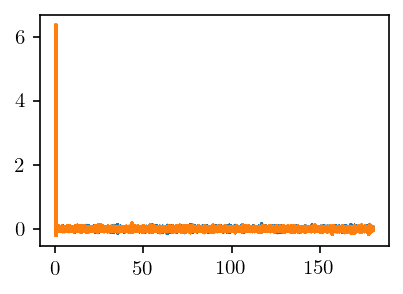

In [16]:
plt.plot(data_IvsT.loc["even"].loc[0].I_x.rolling(20).mean())
plt.plot(data_IvsT.loc["even"].loc[0].I_y.rolling(20).mean())

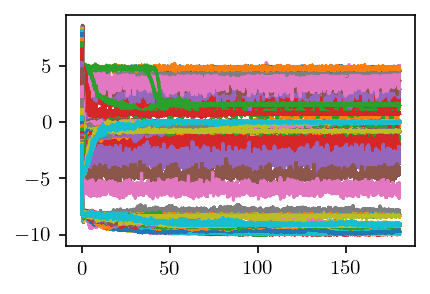

In [17]:
for i, data_i in data_IvsT.loc["even"].groupby("tilt"):
    L = plt.plot(data_IvsT.loc["even"].loc[i].I_x.rolling(20).mean())
    plt.plot(data_IvsT.loc["even"].loc[i].I_y.rolling(20).mean(),
            color = L[0].get_color())

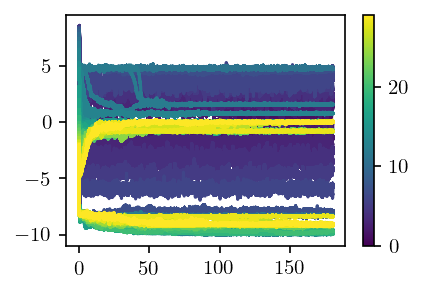

In [18]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in data_IvsT.loc["even"].groupby("tilt"):
    plt.plot(data_IvsT.loc["even"].loc[i].I_x.rolling(20).mean(),
            color = cmap(norm(i)))
    plt.plot(data_IvsT.loc["even"].loc[i].I_y.rolling(20).mean(),
            color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

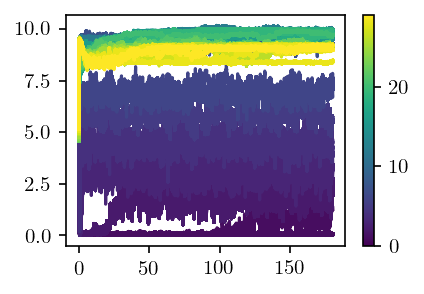

In [19]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in data_IvsT.loc["even"].groupby("tilt"):
    
    I = np.sqrt(data_IvsT.loc["even"].loc[i].I_x.rolling(20).mean()**2+\
        data_IvsT.loc["even"].loc[i].I_y.rolling(20).mean()**2)

    plt.plot(I,color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

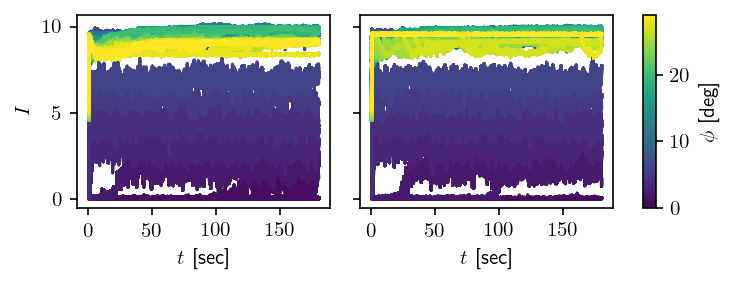

In [21]:
fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True)

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in data_IvsT.loc["even"].groupby("tilt"):
    
    I = np.sqrt(data_IvsT.loc["even"].loc[i].I_x.rolling(20).mean()**2+\
        data_IvsT.loc["even"].loc[i].I_y.rolling(20).mean()**2)

    ax[0].plot(I,color = cmap(norm(i)))
    
    I = np.sqrt(data_IvsT.loc["odd"].loc[i].I_x.rolling(20).mean()**2+\
        data_IvsT.loc["odd"].loc[i].I_y.rolling(20).mean()**2)

    ax[1].plot(I,color = cmap(norm(i)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


### Save the smooth dataset

In [22]:
data_IvsT_smooth = data_IvsT.groupby(level=["parity","tilt"],).rolling(20).mean()
data_IvsT_smooth = data_IvsT_smooth.droplevel([2,3]).filter(["I_x","I_y"])
data_IvsT_smooth["I"] = data_IvsT_smooth.eval("sqrt(I_x**2+I_y**2)")

data_IvsT_smooth.head()

data_IvsT_smooth.to_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

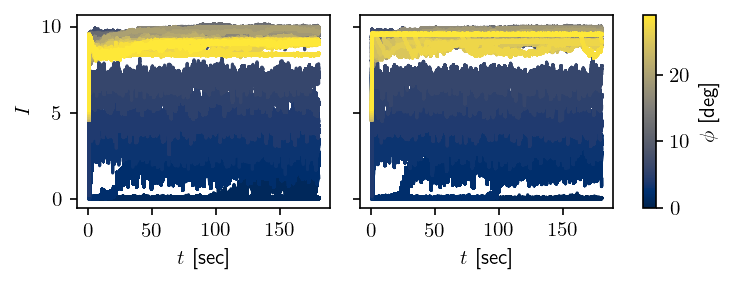

In [23]:
data_IvsT_smooth = pd.read_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True, facecolor="white")

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["cividis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for phi in np.sort(tilts):

    ax[0].plot(data_IvsT_smooth.loc["even"].loc[phi].I, color = cmap(norm(phi)))

    ax[1].plot(data_IvsT_smooth.loc["odd"].loc[phi].I, color = cmap(norm(phi)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


# Visualize final value of the current vs tilt angle $\phi$

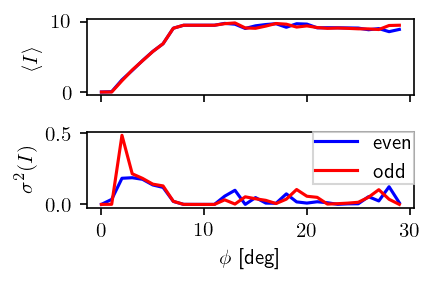

In [24]:
data_IvsPhi = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).mean()

fig, ax = plt.subplots(2,1, sharex=True,
                       figsize=(3,2), facecolor="white",
                       tight_layout=True)

color = ["blue","red"]

ax[0].plot(data_IvsPhi.loc["even"].I,color = color[0])
ax[0].plot(data_IvsPhi.loc["odd"].I,color = color[1])

data_IvsPhi_var = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).var()

ax[1].plot(data_IvsPhi_var.loc["even"].I, color[0], label="even")
ax[1].plot(data_IvsPhi_var.loc["odd"].I, color[1], label="odd")

ax[1].set_xlabel("$\phi$ [deg]")
ax[1].set_ylabel("$\sigma^2(I)$")
ax[0].set_ylabel(r"$\left<I\right>$")

ax[1].legend(
    fancybox=False,
    borderpad=0.1,
    bbox_to_anchor=(1,1),borderaxespad=0
            )

### For some reason, some points are missing. 

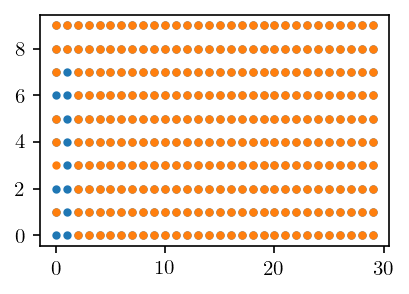

In [28]:
plt.plot(index.query("parity=='even'").tilt, index.query("parity=='even'").exp_n, '.')
plt.plot(index.query("parity=='odd'").tilt, index.query("parity=='odd'").exp_n, '.')

## Why is dispersion not reduced even with statistics?

In [32]:
index = pd.read_hdf(trayectories_file, key = "index")
index.head()

,file,height,tilt,exp_n,max_frame,parity,fid_origin
3,Tilt_0_deg_h3899_2023_08_04_05_30_22,3.9,0,3,1799926,odd,3
4,Tilt_0_deg_h3899_2023_08_04_05_30_22,3.9,0,5,1799926,odd,4
5,Tilt_0_deg_h3899_2023_08_04_05_30_22,3.9,0,7,1799926,odd,5
6,Tilt_0_deg_h3899_2023_08_04_05_30_22,3.9,0,1,1799926,odd,6
7,Tilt_0_deg_h3899_2023_08_04_05_30_22,3.9,0,8,1799926,odd,7


In [33]:
subindex = index.query("tilt==3 & parity=='even'")

In [43]:
aggregate = []

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj = pd.read_hdf(trayectories_file, key = entry.file)
    timeseries = trj.groupby("time").I_x.mean().to_frame("I_x")
    timeseries["I_y"] = trj.groupby("time").I_y.mean()
    timeseries["var_x"] = trj.groupby("time").I_x.var()
    timeseries["var_y"] = trj.groupby("time").I_y.var()
    timeseries["N"] = trj.groupby("time").I.count()
    
    aggregate.append(timeseries)
    
aggregate_pd = pd.concat(aggregate, 
      keys = list(subindex.filter(["tilt","parity","exp_n"]).itertuples(index=False)),
      names = ["tilt","parity","exp_n"])

  0%|          | 0/588 [00:00<?, ?it/s]

In [49]:
aggregate_pd.head()

I_x        I_y      var_x     var_y    N
tilt parity exp_n time                                                  
3    even   0     0.0000        NaN        NaN        NaN       NaN    0
                  0.0167  24.663230   7.104847  16.737047  6.249042  239
                  0.0334  19.095960  10.763107   9.070882  5.216202  239
                  0.0501   2.137236   1.825505   5.884082  5.664625  239
                  0.0668  -8.036910  -5.537584   6.587864  5.972232  239

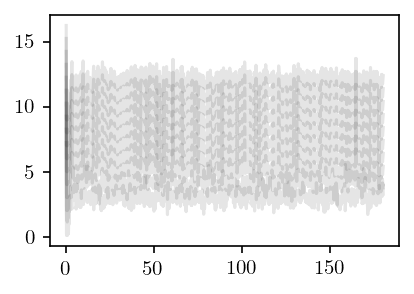

In [63]:
for exp_i, I_i in aggregate_pd.groupby(["tilt","parity","exp_n"]):
    plt.plot(I_i.rolling(20).mean().eval("sqrt(I_x**2+I_y**2)").droplevel([0,1,2])+exp_i[2],
            color = "k", alpha = 0.1) 
    
#plt.plot(aggregate_pd.groupby("time").mean().rolling(20).mean().eval("sqrt(I_x**2+I_y**2)"))

In [58]:
I_i.rolling(20).mean().eval("sqrt(I_x**2+I_y**2)").droplevel([0,1,2])

time
0.0000           NaN
0.0167           NaN
0.0334           NaN
0.0501           NaN
0.0668           NaN
              ...   
179.9258    3.515046
179.9425    3.494903
179.9592    3.449158
179.9759    3.354714
179.9926    3.273604
Length: 10779, dtype: float64

In [ ]:
498885, 498885